In [ ]:
#Spark Exercise 4
#Adornado B. Cabalbag Jr
#BSIT - 3B

In [12]:
!pip install pyspark
!pip install nltk
!pip install vaderSentiment

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace,explode, split, count, when
import nltk
from nltk.corpus import stopwords
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, FloatType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files

In [13]:
nltk.download('stopwords')
spark = SparkSession.builder.appName("UAQTE_Responses_Analysis").getOrCreate()
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = spark.read.csv(file_name, header=True, inferSchema=True)
df.show(truncate=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving UAQTEresponses.csv to UAQTEresponses.csv
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Responses                                                                                                                                                                                                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
df = df.withColumn ("responses", regexp_replace(col("Responses"),r"[^a-zA-z\s]",""))
df = df.withColumn ("responses", lower(col("responses")))

In [45]:
df = df.withColumn ("words", split(col("responses")," "))
stop_words = set(stopwords.words("english"))
additional_stopwords = {"uaqte", "UAQTE", "one", "also"} #Custom stopwords
stop_words.update(additional_stopwords)
df.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
def remove_stopwords(words):
    return [word for word in words if word not in stop_words and word != ""]
remove_stopwords_udf = udf(remove_stopwords, ArrayType(StringType()))
df = df.withColumn("filtered_words", remove_stopwords_udf(col("words")))

In [47]:
df_exploded = df.select(explode(col("filtered_words")).alias("word"))
df_exploded = df_exploded.filter(~col("word").isin(additional_stopwords))
word_counts = df_exploded.groupBy("word").count().orderBy(col("count").desc())
word_counts.show(20)

+-------------+-----+
|         word|count|
+-------------+-----+
|    education|   34|
|      tuition|   34|
|         free|   27|
|    financial|   26|
|         help|   26|
|      college|   21|
|       helped|   21|
|       family|   19|
|beneficiaries|   19|
|         able|   19|
|        study|   18|
|      parents|   15|
|     expenses|   15|
|         much|   15|
|       school|   14|
|        helps|   14|
|          lot|   14|
|      studies|   14|
|       burden|   11|
|      program|   11|
+-------------+-----+
only showing top 20 rows



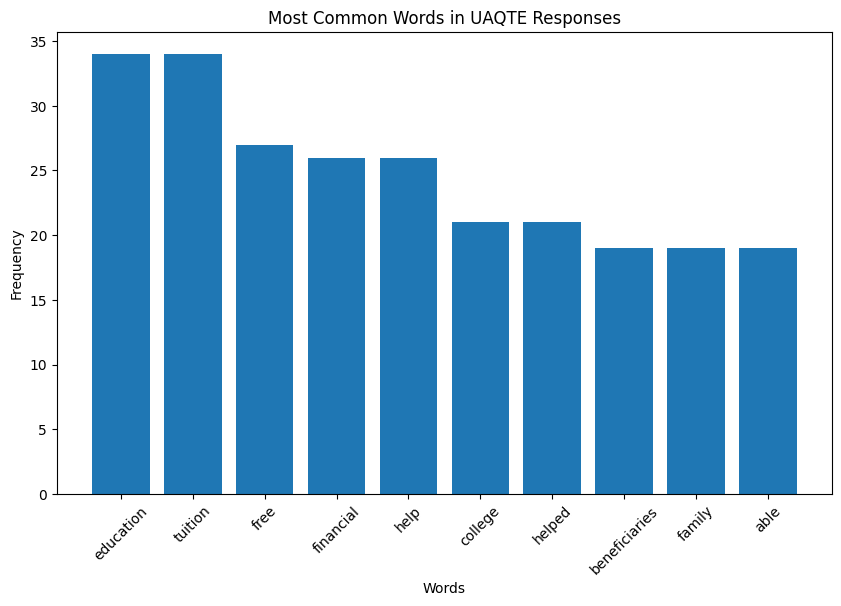

In [48]:
#Convert to Pandas for visualization

word_counts_pd = word_counts.limit(10).toPandas()

#Plotbar chart
plt.figure(figsize=(10, 6))
plt.bar(word_counts_pd["word"], word_counts_pd["count"])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in UAQTE Responses")
plt.xticks(rotation=45)
plt.show()

In [49]:
#Sentiment Analysis using VADER

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
  scores = analyzer.polarity_scores(text)
  return scores['compound']

sentiment_udf = udf(get_sentiment, FloatType())

df = df.withColumn("sentiment_score", sentiment_udf(col("responses")))

In [50]:
#Show sentiment results
df.select("responses", "sentiment_score").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|responses                                                                                                                                                                                                                                                                                                                                                                                      |sentiment_score|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [51]:
#Categorize sentiment
df = df.withColumn ("sentiment",
                  when(col("sentiment_score") > 0.05, "Positive")
                  .when(col("sentiment_score") < 0.05, "Negative")
                  .otherwise("Neutral")
                  )

In [52]:
#Show categorized sentiment
df.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| Positive|   94|
| Negative|   11|
+---------+-----+



In [53]:
#Creating a Bar Chart that Displays Percentage of Sentiments
import matplotlib.pyplot as plt

#Get sentiment counts
sentiment_counts = df.groupBy("sentiment").count()

#Convert to Pandas
sentiment_counts_pd = sentiment_counts.toPandas()

#Calculate Total responses
total_responses = sentiment_counts_pd["count"].sum()

#Compute percentage for each sentiment
sentiment_counts_pd["percentage"] = (sentiment_counts_pd["count"] / total_responses) * 100

#Sort for better visualization (optional)
sentiment_counts_pd = sentiment_counts_pd.sort_values(by="percentage", ascending=False)


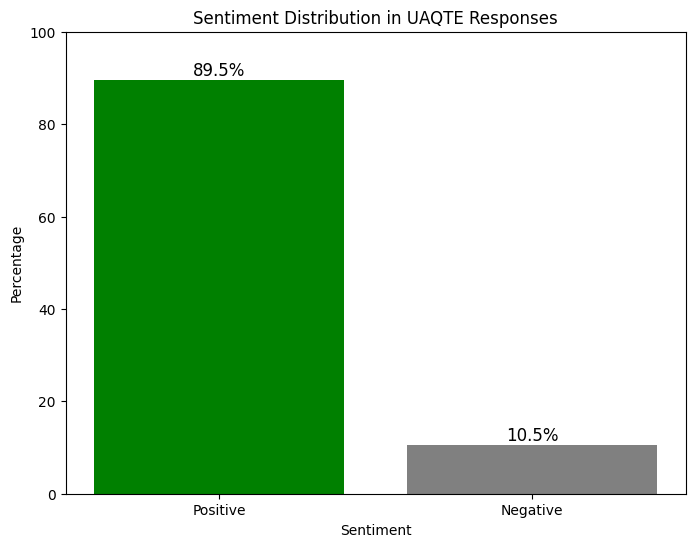

In [54]:
#Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts_pd["sentiment"], sentiment_counts_pd["percentage"], color = ["green", "gray", "red"])
plt.xlabel("Sentiment")
plt.ylabel("Percentage")
plt.title("Sentiment Distribution in UAQTE Responses")
plt.ylim(0, 100) #Set y-axis limit to 100%
plt.xticks(rotation = 0) #Ensure labels are readable

#Show percentage on top of bars
for i, v in enumerate(sentiment_counts_pd["percentage"]):
    plt.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=12)

plt.show()

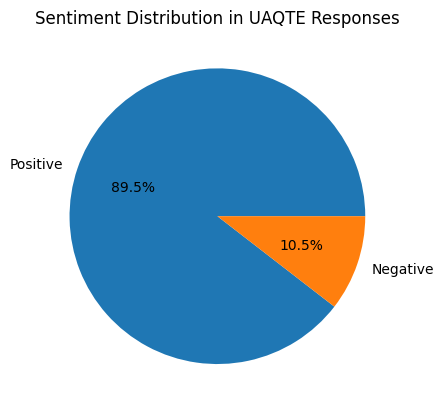

In [55]:
#Pie Chart
plt.pie(sentiment_counts_pd["percentage"], labels=sentiment_counts_pd["sentiment"], autopct="%1.1f%%")
colors = ["green", "gray", "red"]
plt.title("Sentiment Distribution in UAQTE Responses")
plt.show()

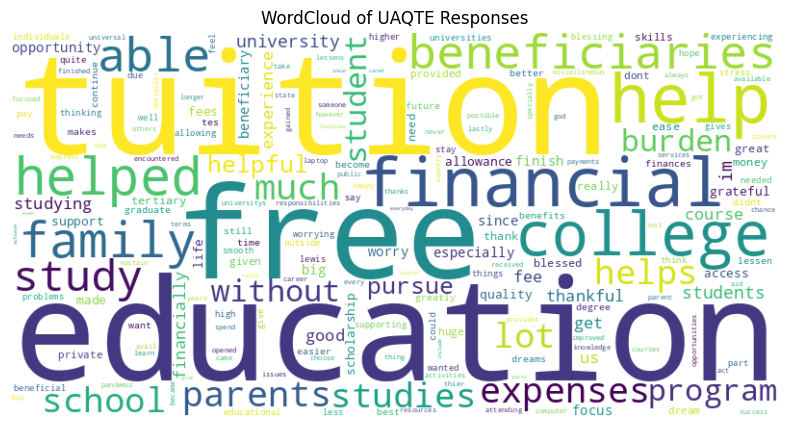

In [56]:
#Word Cloud
from wordcloud import WordCloud

#Convert word counts to pandas for visualization
word_counts_pd = word_counts.toPandas()

#Convert word frequency data to a dictionary
word_freq_dict = dict(zip(word_counts_pd["word"], word_counts_pd["count"]))

#Generate word cloud
wordcloud = WordCloud(width=800, height=400,
                      background_color="white").generate_from_frequencies(word_freq_dict)

#Display Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title ("WordCloud of UAQTE Responses")
plt.show()